In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.utils import resample
# For modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso, lasso_path, lars_path
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap
#sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data (pickle file) after the preprocessing from the preprocessing notebook/part

In [2]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [3]:
# TAKE SUBSAMPLE OF DATA FOR COMPUTATION ISSUES (TODO: DELETE THIS LATER)
df = df.sample(frac = 0.1)
print(df.shape)

(134531, 101)


---
# Model Preprocessing: Encode Features from categorical to numerical
In this section we prepare our data set for modeling through fixing the inbalancement of our data, encoding categorical data, dropping features that are only apriori the application known etc...

## Drop columns for prediction
In this small section we drop features that we do not have prior the lending application. We consulted the data dictionary table (seen [here](https://docs.google.com/spreadsheets/d/13YQDRQYYbr84wy7zQ91yfC8QoEBFPFP0zR5pIDf18rA/edit#gid=629438262)) and analyzed which columns to keep and which to drop. Note that this requires a lot of domain knowledge.

In [4]:
keep_list = ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'loan_status', 'mort_acc', 'num_bc_tl', 'num_bc_sats', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'total_bc_limit', 'total_il_high_credit_limit', 'verification_status', 'zip_code']

cols_to_drop = [col for col in df.columns if col not in keep_list]
print(f"Cols to drop: {cols_to_drop}")
df.drop(cols_to_drop, axis=1, inplace=True)
print(f"Shape of df after drop: {df.shape}")

Cols to drop: ['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 

In [5]:
# Convert term to float32
df["term"] = df["term"].astype(np.float64)

# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# Preview
print(f"Current categorical features:\n{cat_columns}")

float64    22
object      8
int32       1
dtype: int64
Current categorical features:
['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']


### Deleted irrelevant categorical features
Delete categorical features that are not relevant for the Modelling or contain too many realization so that encoding them would be infeasible.

In [6]:
# Define categorical columns from cat_columns to keep here
CAT_COLS_TO_KEEP = ["home_ownership", "grade", "sub_grade", "verification_status", "application_type", "initial_list_status"]
CAT_COLS_TO_DROP = [col for col in cat_columns if col not in CAT_COLS_TO_KEEP]

print(f"Categorical Columns to drop: {CAT_COLS_TO_DROP}")
print(f"Categorical Columns to keep: {CAT_COLS_TO_KEEP}\n")
print(f"Shape of df before columns drop: {df.shape}")
# Drop irrelevant categorical features
df.drop(CAT_COLS_TO_DROP, axis=1, inplace=True)
print(f"Shape of df after columns drop: {df.shape}")

Categorical Columns to drop: ['purpose', 'addr_state']
Categorical Columns to keep: ['home_ownership', 'grade', 'sub_grade', 'verification_status', 'application_type', 'initial_list_status']

Shape of df before columns drop: (134531, 31)
Shape of df after columns drop: (134531, 29)


## Preview of the remaining categorical features

In [7]:
print(df.dtypes.value_counts())
df.select_dtypes("object")

float64    22
object      6
int32       1
dtype: int64


,grade,sub_grade,home_ownership,verification_status,initial_list_status,application_type
1145377,A,A2,RENT,Not Verified,f,Individual
1344597,C,C3,MORTGAGE,Source Verified,w,Individual
177328,B,B1,OWN,Source Verified,f,Individual
1803078,E,E2,MORTGAGE,Verified,f,Individual
1170037,B,B5,RENT,Verified,f,Individual
...,...,...,...,...,...,...
404883,D,D1,MORTGAGE,Verified,w,Individual
1908523,D,D5,MORTGAGE,Verified,f,Individual
2017534,C,C2,OWN,Source Verified,w,Individual
674917,F,F3,RENT,Verified,w,Individual


In [8]:
# Preview of all remaining columns / features:
print(df.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'dti', 'fico_range_low', 'fico_range_high', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'last_fico_range_high', 'last_fico_range_low',
       'application_type', 'mort_acc', 'num_bc_sats', 'num_bc_tl',
       'pub_rec_bankruptcies', 'total_bc_limit', 'total_il_high_credit_limit'],
      dtype='object')


## Create Dummy Variables

In [9]:
# Binary Encoding
import category_encoders as ce
print(f"Shape before dummies using BinaryEncoder: {df.shape}")
# Encode categorical columns
encoder = ce.BinaryEncoder(cols=CAT_COLS_TO_KEEP)
df_binary = encoder.fit_transform(df)
print(f"Shape after dummies using BinaryEncoder: {df_binary.shape}")
# check
df_binary.dtypes.value_counts()

Shape before dummies using BinaryEncoder: (134531, 29)
Shape after dummies using BinaryEncoder: (134531, 41)


float64    22
int64      18
int32       1
dtype: int64

In [10]:
# Use pd.get_dummies instead
#print(f"Shape before dummies using pd.get_dummies(): {df.shape}")
#df_binary = pd.get_dummies(data=df, columns=CAT_COLS_TO_KEEP, drop_first=True)
#print(f"Shape after dummies using pd.get_dummies(): {df_binary.shape}")

In [11]:
# Convert all values to float
df_binary = df_binary.astype(np.float32)
df_binary.dtypes.value_counts()

float32    41
dtype: int64

## Preview preprocessed dataframe

In [12]:
df_binary.head(10)

,loan_amnt,term,int_rate,installment,grade_0,grade_1,grade_2,sub_grade_0,sub_grade_1,sub_grade_2,...,last_fico_range_high,last_fico_range_low,application_type_0,application_type_1,mort_acc,num_bc_sats,num_bc_tl,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit
1145377,12000.0,36.0,6.49,367.739990,0.0,0.0,1.0,0.0,0.0,0.0,...,579.0,575.0,0.0,1.0,0.0,10.0,14.0,1.0,22700.0,153979.0
1344597,33950.0,60.0,14.98,807.320007,0.0,1.0,0.0,0.0,0.0,0.0,...,819.0,815.0,0.0,1.0,5.0,5.0,12.0,0.0,42300.0,25123.0
177328,8000.0,36.0,8.18,251.360001,0.0,1.0,1.0,0.0,0.0,0.0,...,724.0,720.0,0.0,1.0,2.0,5.0,10.0,0.0,17800.0,34368.0
1803078,20000.0,60.0,21.15,542.760010,1.0,0.0,0.0,0.0,0.0,0.0,...,659.0,655.0,0.0,1.0,5.0,6.0,11.0,0.0,18600.0,117877.0
1170037,5000.0,36.0,12.49,167.250000,0.0,1.0,1.0,0.0,0.0,0.0,...,719.0,715.0,0.0,1.0,0.0,6.0,7.0,1.0,5600.0,48430.0
2240863,31000.0,36.0,8.24,974.869995,0.0,1.0,1.0,0.0,0.0,0.0,...,809.0,805.0,0.0,1.0,2.0,8.0,10.0,0.0,49300.0,105164.0
2229278,35000.0,36.0,11.44,1153.170044,0.0,1.0,1.0,0.0,0.0,0.0,...,689.0,685.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,24137.0
1174744,4000.0,36.0,13.35,135.460007,0.0,1.0,0.0,0.0,0.0,0.0,...,504.0,500.0,0.0,1.0,0.0,3.0,9.0,0.0,11100.0,13000.0
1204966,5400.0,36.0,7.69,168.449997,0.0,0.0,1.0,0.0,0.0,1.0,...,774.0,770.0,0.0,1.0,1.0,7.0,9.0,0.0,23500.0,419091.0
284322,10000.0,36.0,11.53,329.910004,0.0,1.0,1.0,0.0,0.0,0.0,...,709.0,705.0,0.0,1.0,6.0,3.0,5.0,1.0,9700.0,45781.0


## Create Balanced Data Set via Downsampling

0.0    107502
1.0     27029
Name: loan_status, dtype: int64
(134531, 41)


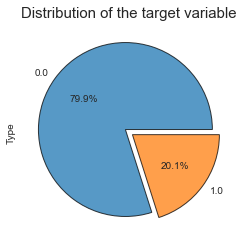

In [13]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)

plt.title("Distribution of the target variable", size=15)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.05, 0.05])
plt.show()

0.0    35138
1.0    27029
Name: loan_status, dtype: int64


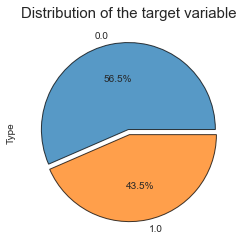

In [14]:
# Downsampling
loan_status_0 = df_binary[df_binary["loan_status"] == 0.0]
loan_status_1  = df_binary[df_binary["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
# Plot settings
plt.title("Distribution of the target variable", size=15)
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.03, 0.03])
plt.show()

## Data Imputation
Since we still have some NaNs in our feature, we replace them by taking the median values.

In [15]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,term,int_rate,installment,grade_0,grade_1,grade_2,sub_grade_0,sub_grade_1,sub_grade_2,...,last_fico_range_high,last_fico_range_low,application_type_0,application_type_1,mort_acc,num_bc_sats,num_bc_tl,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit
1886928,15000.0,36.0,6.03,456.540009,0.0,0.0,1.0,0.0,1.0,0.0,...,674.0,670.0,0.0,1.0,5.0,7.0,10.0,0.0,30700.0,102105.0
299803,24000.0,60.0,17.57,603.849976,1.0,0.0,1.0,0.0,1.0,0.0,...,759.0,755.0,0.0,1.0,0.0,5.0,8.0,0.0,21600.0,48280.0
693936,1000.0,36.0,12.99,33.689999,0.0,1.0,0.0,0.0,0.0,0.0,...,734.0,730.0,0.0,1.0,0.0,5.0,9.0,0.0,7200.0,6500.0
1086614,15000.0,60.0,13.44,344.690002,0.0,1.0,0.0,0.0,0.0,0.0,...,699.0,695.0,0.0,1.0,0.0,4.0,7.0,0.0,19400.0,35958.0
997577,20000.0,36.0,19.99,743.169983,1.0,0.0,0.0,0.0,1.0,0.0,...,689.0,685.0,0.0,1.0,0.0,5.0,9.0,0.0,20200.0,22561.0


## Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [16]:
# Fraction of test data
TEST_SIZE = 0.2

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=1997, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (49733, 40)
Shape of X_test: (12434, 40)
Shape of y_train: (49733,)
Shape of y_test: (12434,)


## Scaling
We scale the data with the MinMaxScaler to a range of $[0, 1]$

In [17]:
# Init object
scaler = MinMaxScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(10)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.871795,1.0,0.730919,0.581601,1.0,1.0,0.0,1.0,0.0,0.0,...,0.512820,0.798817,0.0,1.0,0.241379,0.079365,0.471429,0.166667,0.012865,0.004724
1,0.627564,0.0,0.341900,0.500932,0.0,1.0,1.0,0.0,0.0,0.0,...,0.299145,0.710059,0.0,1.0,0.137931,0.047619,0.071429,0.000000,0.051023,0.050291
2,0.743590,1.0,0.401090,0.413343,1.0,0.0,1.0,0.0,0.0,1.0,...,0.142450,0.644970,0.0,1.0,0.103448,0.126984,0.157143,0.000000,0.083187,0.100724
3,0.435897,0.0,0.084891,0.316868,0.0,0.0,1.0,0.0,0.0,1.0,...,0.498575,0.792899,0.0,1.0,0.000000,0.047619,0.114286,0.000000,0.020175,0.012243
4,0.051282,0.0,0.523365,0.051214,1.0,0.0,1.0,0.0,1.0,1.0,...,0.042735,0.603550,0.0,1.0,0.000000,0.015873,0.100000,0.000000,0.000439,0.027229
5,0.692308,1.0,0.299065,0.362371,0.0,1.0,0.0,0.0,0.0,0.0,...,0.541311,0.810651,0.0,1.0,0.068966,0.095238,0.157143,0.000000,0.065497,0.015822
6,0.343590,0.0,0.357477,0.278970,0.0,1.0,0.0,0.0,0.0,1.0,...,0.071225,0.615385,0.0,1.0,0.000000,0.126984,0.114286,0.000000,0.040205,0.026592
7,0.163462,0.0,0.230140,0.129469,0.0,1.0,1.0,0.0,0.0,0.0,...,0.227920,0.680473,0.0,1.0,0.103448,0.031746,0.057143,0.000000,0.005263,0.040660
8,0.487180,0.0,0.322430,0.387523,0.0,1.0,0.0,0.0,0.0,0.0,...,0.185185,0.662722,0.0,1.0,0.034483,0.079365,0.085714,0.000000,0.021930,0.083267
9,0.358974,1.0,0.287383,0.186531,0.0,1.0,0.0,0.0,0.0,0.0,...,0.313390,0.715976,0.0,1.0,0.068966,0.015873,0.100000,0.000000,0.011696,0.037676


---
# Task 3: Logistic Regression In Sample
Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression

In [18]:
# Fit Model via GridSearch + Cross Validation
param_grid = {"tol": [0.01, 0.001, 0.0001],
              'fit_intercept': [True, False],
              'max_iter': [1000],
              'C': [1, 2, 3]}
# Apply GridSearch with above defined grid
grid_cv = GridSearchCV(estimator = LogisticRegression(),
                       param_grid=param_grid,
                       n_jobs=-1,
                       cv=5)
# Fit Grid CV with Trainingsset
grid_cv.fit(X_train_scaled, y_train)
# Output best params
print(f"Best params: {grid_cv.best_params_} with a score of {grid_cv.best_score_:.4f}")

Best params: {'C': 2, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.01} with a score of 0.8878


In [19]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cv_results = cv_results.sort_values(by="rank_test_score", ascending=True)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,1.501787,0.064984,0.005984,0.001995,2,True,1000,0.0001,"{'C': 2, 'fit_intercept': True, 'max_iter': 10...",0.8868,0.885493,0.886498,0.890107,0.890006,0.887781,0.001908,1
6,1.468275,0.043749,0.004588,0.000489,2,True,1000,0.01,"{'C': 2, 'fit_intercept': True, 'max_iter': 10...",0.8868,0.885493,0.886498,0.890107,0.890006,0.887781,0.001908,1
7,1.478049,0.045829,0.004588,0.000488,2,True,1000,0.001,"{'C': 2, 'fit_intercept': True, 'max_iter': 10...",0.8868,0.885493,0.886498,0.890107,0.890006,0.887781,0.001908,1
9,0.961231,0.061530,0.004787,0.000399,2,False,1000,0.01,"{'C': 2, 'fit_intercept': False, 'max_iter': 1...",0.8867,0.885292,0.886498,0.890308,0.890006,0.887761,0.002017,4
10,0.995938,0.090872,0.004787,0.000399,2,False,1000,0.001,"{'C': 2, 'fit_intercept': False, 'max_iter': 1...",0.8867,0.885292,0.886498,0.890308,0.890006,0.887761,0.002017,4


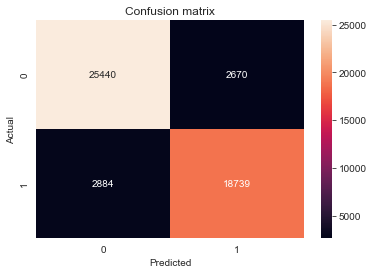

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     28110
         1.0       0.88      0.87      0.87     21623

    accuracy                           0.89     49733
   macro avg       0.89      0.89      0.89     49733
weighted avg       0.89      0.89      0.89     49733



In [20]:
# Perform Logistic Regression on the best estimator selected by above Cross Validation
y_pred = grid_cv.predict(X_train_scaled)

# Plot Confusion matrix for in sample (y_train instead of y_test)
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(classification_report(y_true=y_train, y_pred=y_pred))

## Interpretation:
We achieve an accuracy of around 90% for our in-sample prediction. This seems good but not perfect considering that we test the model on seen data (i.e. Trainings data). However, through the beginning feature selection (keeping only features that we have at the beginning of a loan application) this is still a very good indicator whether we should accept or decline a loan application.

---
# Task 4: Compare different classification models
Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network

for default prediction based on the out-of-sample performance measures (at least three different measures).

In [21]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=1000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC_rbf",SVC(kernel='rbf', max_iter=500)))
models.append(("SVC_poly",SVC(kernel="poly", max_iter=500)))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
# Define scoring metrices for CV
scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"]
for name, model in tqdm(models):
    result = cross_validate(model, X_train_scaled, y_train,  cv=3, n_jobs=-1, scoring=scoring)
    names.append(name)
    results.append(result)

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: total: 219 ms
Wall time: 52.6 s


In [22]:
# Get name of metrices (will be column in result_df)
metrices = list(results[0].keys())
# Create empty dataframe
results_df = pd.DataFrame(index=names, columns=metrices, dtype="float32")

# File dataframe by iterating over all results and taking the mean value
for i, name in enumerate(models):
    mean_of_metrices = []
    for key in results[i].keys():
        mean_of_metrices.append(results[i].get(key).mean())
    results_df.iloc[i] = mean_of_metrices

# Drop scoring_time column as it is not of interest
results_df.drop("score_time", axis=1, inplace=True)
# Round to 4 decimal places
results_df = results_df.round(decimals=4)
# Sort descending of f1 score
results_df = results_df.sort_values(by="test_f1_micro", ascending=False)
# Preview
results_df

,fit_time,test_accuracy,test_precision_micro,test_recall_micro,test_f1_micro
RandomForest,6.4262,0.9013,0.9013,0.9013,0.9013
NeuronalNetwork,24.2502,0.8885,0.8885,0.8885,0.8885
LogisticRegression,1.5901,0.8878,0.8878,0.8878,0.8878
BaggingCLF,4.1320,0.8865,0.8865,0.8865,0.8865
DecisionTree,0.7048,0.8428,0.8428,0.8428,0.8428
SVC_rbf,2.9720,0.6628,0.6628,0.6628,0.6628
SVC_poly,2.9175,0.4986,0.4986,0.4986,0.4986


## Results:
We can see that a RandomForest Model performs the best according to the f1 score, which is the harmonic mean between recall and precision. Also LogisticRegression, as a very good interpretable model, performs pretty well and is ranked 2nd. SVC, on the other hands, perform very poorly.

---
# Task 5: Use LASSO for feature selection and explain results

In [23]:
features = X_train.columns

Do Hyperparameter Tuning for LASSO. Especially in order to find the perfect lambda serving as a control variable for the relative impact of the regularization for LASSO and also decides what features are selected.

In [26]:
%%time
# Use StandardScaler for LASSO
X_train_standardized = StandardScaler().fit_transform(X_train)

# define parameters
param_grid = param = {
    'alpha':[0.0001, 0.001, 0.01],
    'fit_intercept':[True,False],
    'positive':[True,False],
    'selection':['cyclic','random'],
    }

# define search
search = GridSearchCV(Lasso(max_iter=10000),
                      param_grid,
                      cv = 5, scoring="neg_mean_squared_error",verbose=1
                      )
# execute search
search.fit(X_train_standardized,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 29.1 s
Wall time: 9.48 s


GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'fit_intercept': [True, False],
                         'positive': [True, False],
                         'selection': ['cyclic', 'random']},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
# summarize result
print(f"Best Score: {search.best_score_}")
print(f"Best Hyperparameters: {search.best_params_}")
best_alpha = search.best_params_.get("alpha")

Best Score: -0.09833237379789353
Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'positive': False, 'selection': 'random'}


Having found the best estimator we now can take a look which features we keep and which we discard.

In [28]:
# values of the coefficients
coefficients = search.best_estimator_.coef_
# importance of a feature = absolute value of its coefficient
importance = np.abs(coefficients)
assert(len(features) == len(importance))
# selected features
selected_features = np.array(features)[importance > 0]
# discarded features
discarded_features = np.array(features)[importance == 0]

**Feature Selection**

Trough selecting alpha = 0.0001, the feature importance is reduced, where the feature importance itself is the absolute value of its coefficient. Therefore, a discarded features importance is denoted by zero value given in the below table and on the other hand those we will keep are denoted by higher value as zero.



In [29]:
print(f"Importances: \n {importance} \n" + "-" * 60)
print(f"Selected Features: {selected_features} \n" + "-" * 60)
print(f"Discarded Features: {discarded_features} \n" + "-" * 60)

Importances: 
 [2.1309825e-02 4.8387341e-02 9.5796585e-03 4.6679176e-02 1.2659178e-02
 2.8561598e-03 7.5225746e-03 4.4943406e-03 4.0338594e-03 1.7927365e-03
 5.6876448e-05 3.7503010e-03 2.2091093e-03 2.1524096e-03 7.2517968e-04
 4.0531913e-03 6.5689133e-03 7.4720047e-03 2.3764505e-03 1.9399134e-03
 1.4664615e-02 2.1202793e-02 1.8763455e-02 5.8461819e-03 5.1089912e-03
 1.7945075e-03 7.1479264e-03 1.0718510e-02 1.8489941e-04 3.4644564e-03
 4.1189542e-01 4.0508512e-02 1.1671691e-05 5.3835986e-03 3.0051116e-03
 1.2467617e-02 3.3007271e-03 4.7706391e-04 9.8880948e-03 1.1269550e-02] 
------------------------------------------------------------
Selected Features: ['loan_amnt' 'term' 'int_rate' 'installment' 'grade_0' 'grade_1' 'grade_2'
 'sub_grade_0' 'sub_grade_1' 'sub_grade_2' 'sub_grade_3' 'sub_grade_4'
 'sub_grade_5' 'emp_length' 'home_ownership_0' 'home_ownership_1'
 'home_ownership_2' 'annual_inc' 'verification_status_0'
 'verification_status_1' 'dti' 'fico_range_low' 'fico_range_high'


## Lasso Paths

In [30]:
alphas_lasso, coeffs_lasso, _ = lasso_path(X_train_standardized, y_train, n_alphas=X_train_standardized.shape[1])

In [31]:
# Create DataFrame with coefficients and alpha from lasso
lasso_paths_df = pd.DataFrame(coeffs_lasso, index=X.columns)
# Let the index be the features and the columns be the alphas for plotting reasons
lasso_paths_df.columns = -np.log10(alphas_lasso)
# use log transformation for better visualization

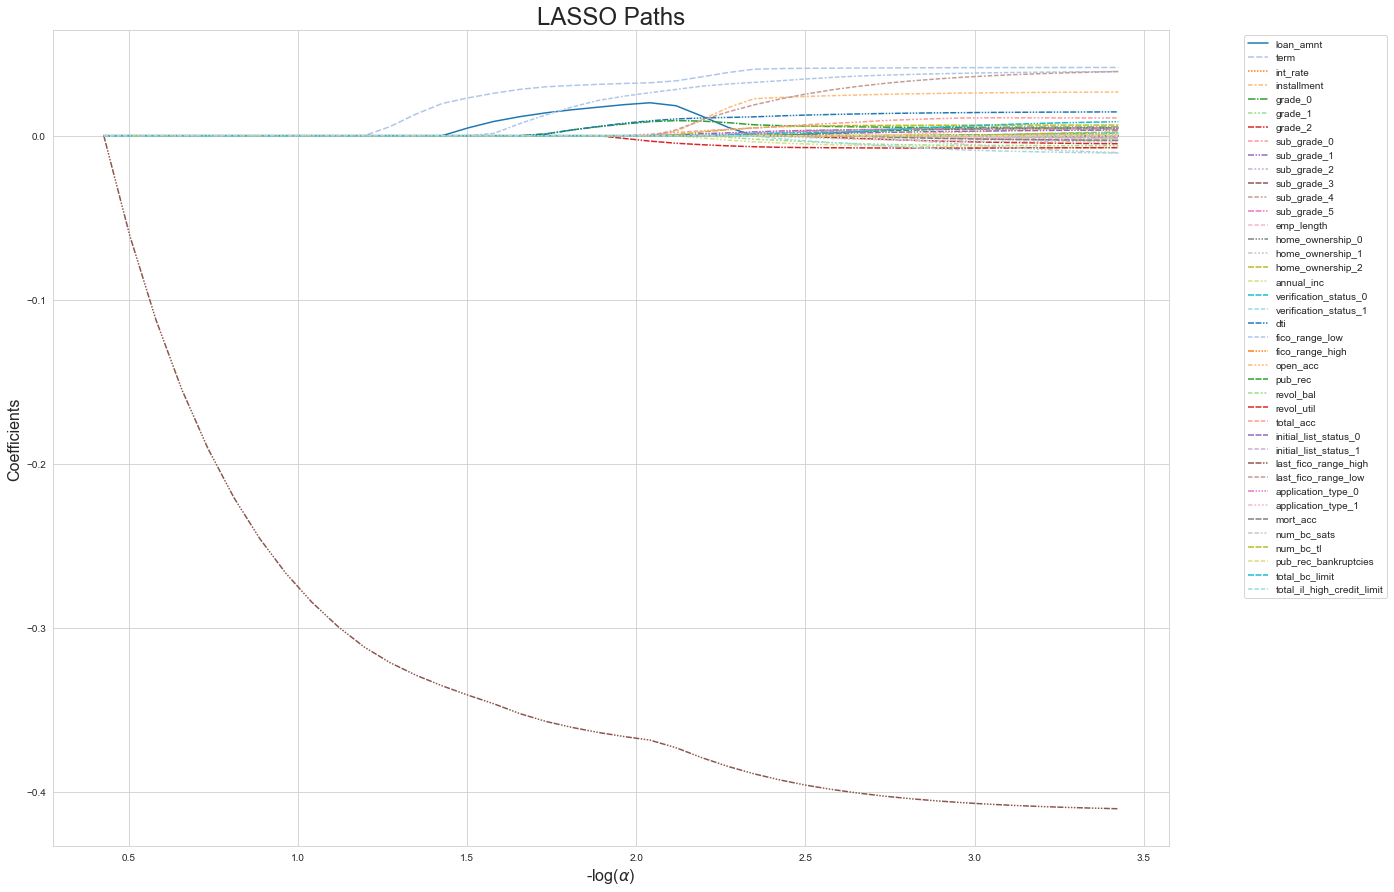

In [32]:
plt.figure(figsize=(20, 15))
plt.title("LASSO Paths", size=24)
sns.lineplot(data=lasso_paths_df.T, palette="tab20")
plt.legend(bbox_to_anchor=(1.2, 1))
plt.xlabel("-log($\\alpha$)", size=16)
plt.ylabel("Coefficients", size=16)
plt.show()

We can see in the LASSO Paths that the int_rate seems to be the most important feature for the target variable

---
# Task 6: Which model do you suggest to the peer-to-peer company? Why?
We rate each model based on the following four criterias learned on the lecture:
- Interpretability
- Robustness
- Speed
- Scalability

In [33]:
results_df.head(10)

,fit_time,test_accuracy,test_precision_micro,test_recall_micro,test_f1_micro
RandomForest,6.4262,0.9013,0.9013,0.9013,0.9013
NeuronalNetwork,24.2502,0.8885,0.8885,0.8885,0.8885
LogisticRegression,1.5901,0.8878,0.8878,0.8878,0.8878
BaggingCLF,4.1320,0.8865,0.8865,0.8865,0.8865
DecisionTree,0.7048,0.8428,0.8428,0.8428,0.8428
SVC_rbf,2.9720,0.6628,0.6628,0.6628,0.6628
SVC_poly,2.9175,0.4986,0.4986,0.4986,0.4986


## Results
Above we can see the final result table sorted decreasingly by the f1 score. We can see that RandomForest is slightly better than LogisticRegression. However, RandomForest lack the interpretability that LogisticRegression has. Also LogisticRegression is still considered a very fast model that is also robust and scales well. If we are more considered about the accuarcy, a Neuronal Network would also be a good choice. Note that we did not do any hyperparameter tuning for NN due to time reason and we did not build a custom network using popular frameworks such as tensorflow. We are sure, that a NN would have a better accuracy. However, it comes with the lack of interpretability, i.e. Neuronal Networks are black boxes in terms of interpretability.

**To summarize: We would recommend the **LogisticRegression** for the Peer 2 Peer LendingClub as a fast, good interpretable, good scalable and robust model.**